<a href="https://colab.research.google.com/github/wantor-stack/Demand-Forecasting/blob/main/ensemble_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PYCARET

In [ ]:
# install the full version
!pip install pycaret

In [ ]:
!pip install -U pandas-profiling


In [ ]:
!pip install fastparquet

In [ ]:
# read the parquet file
import pandas as pd

data = pd.read_parquet("stacked_df.parquet").sort_values("Date")

In [ ]:
data.head()

,Warehouse,Product_Category,Product_Code,Date,Order_Demand
12782,Whse_A,Category_005,Product_0001,2012-01-01,0.0
825352,Whse_C,Category_005,Product_0469,2012-01-01,0.0
4806032,Whse_S,Category_021,Product_0337,2012-01-01,0.0
942216,Whse_C,Category_015,Product_0463,2012-01-01,0.0
4807858,Whse_S,Category_021,Product_0342,2012-01-01,0.0


In [ ]:
# combine store and item column as time_series

data['Warehouse'] = ['warehouse_' + str(i) for i in data['Warehouse']]
data['Product_Code'] = ['Product_Code' + str(i) for i in data['Product_Code']]
data['time_series'] = data[['Warehouse', 'Product_Code']].apply(lambda x: '_'.join(x), axis=1)
data.drop(['Warehouse', 'Product_Category','Product_Code'], axis=1, inplace=True)

In [ ]:
# extract features from date
data['day'] = [i.day for i in data['Date']]
data['month'] = [i.month for i in data['Date']]
data['year'] = [i.year for i in data['Date']]
data['day_of_week'] = [i.dayofweek for i in data['Date']]
data['day_of_year'] = [i.dayofyear for i in data['Date']]


In [ ]:
data = data.sort_values(by=['time_series','Date'])

In [ ]:
# check the unique time_series
data['time_series'].unique()

array(['warehouse_Whse_A_Product_CodeProduct_0001',
       'warehouse_Whse_A_Product_CodeProduct_0020',
       'warehouse_Whse_A_Product_CodeProduct_0031', ...,
       'warehouse_Whse_S_Product_CodeProduct_2167',
       'warehouse_Whse_S_Product_CodeProduct_2168',
       'warehouse_Whse_S_Product_CodeProduct_2169'], dtype=object)

In [ ]:
split_year = 2016

data_train = data[(data['year'] < split_year)]
data_test = data[(data['year'] >= split_year)]
data_train.shape,  data_test.shape

((4162389, 8), (1039885, 8))

In [ ]:
# plot multiple time series with moving avgs in a loop
import plotly.express as px

for i in data_train['time_series'].unique():
    subset = data_train[data_train['time_series'] == i]
    subset['moving_average'] = subset['Order_Demand'].rolling(30).mean()
    fig = px.line(subset, x="Date", y=["Order_Demand","moving_average"], title = i, template = 'plotly_dark')
    fig.show()

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202274 entries, 12782 to 4995935
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Date          datetime64[ns]
 1   Order_Demand  float64       
 2   time_series   object        
 3   day           int64         
 4   month         int64         
 5   year          int64         
 6   day_of_week   int64         
 7   day_of_year   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 357.2+ MB


In [ ]:
data_train.isnull().sum()

Date            0
Order_Demand    0
time_series     0
day             0
month           0
year            0
day_of_week     0
day_of_year     0
dtype: int64

In [ ]:
subset = data_train[data_train['time_series'] == 'warehouse_Whse_A_Product_CodeProduct_0001']
subset['moving_average'] = subset['Order_Demand'].rolling(30).mean()


In [ ]:
subset.isna().sum()

Date               0
Order_Demand       0
time_series        0
day                0
month              0
year               0
day_of_week        0
day_of_year        0
moving_average    29
dtype: int64

In [ ]:
fig = px.line(subset, x="Date", y=['Order_Demand','moving_average'], title = i, template = 'plotly_dark')
fig.show()

In [ ]:
data_train.shape

(4162389, 8)

In [ ]:
data_train['time_series'].value_counts()

warehouse_Whse_J_Product_CodeProduct_1096    1461
warehouse_Whse_J_Product_CodeProduct_1901    1461
warehouse_Whse_A_Product_CodeProduct_1513    1461
warehouse_Whse_C_Product_CodeProduct_1470    1461
warehouse_Whse_J_Product_CodeProduct_1242    1461
                                             ... 
warehouse_Whse_C_Product_CodeProduct_0620    1461
warehouse_Whse_A_Product_CodeProduct_0899    1461
warehouse_Whse_J_Product_CodeProduct_1477    1461
warehouse_Whse_S_Product_CodeProduct_1312    1461
warehouse_Whse_J_Product_CodeProduct_0502    1461
Name: time_series, Length: 2849, dtype: int64

In [ ]:
data_train['time_series'].nunique()

2849

In [ ]:
all_ts = data_train['time_series'].unique()

In [ ]:
all_ts[113:2849]

array(['warehouse_Whse_A_Product_CodeProduct_0442',
       'warehouse_Whse_A_Product_CodeProduct_0453',
       'warehouse_Whse_A_Product_CodeProduct_0454', ...,
       'warehouse_Whse_S_Product_CodeProduct_2167',
       'warehouse_Whse_S_Product_CodeProduct_2168',
       'warehouse_Whse_S_Product_CodeProduct_2169'], dtype=object)

In [ ]:
all_ts=['warehouse_Whse_J_Product_CodeProduct_1359', 'warehouse_Whse_J_Product_CodeProduct_1248', 
        'warehouse_Whse_S_Product_CodeProduct_0083', 'warehouse_Whse_C_Product_CodeProduct_0083',
        'warehouse_Whse_J_Product_CodeProduct_0083', 'warehouse_Whse_S_Product_CodeProduct_1341',
        'warehouse_Whse_C_Product_CodeProduct_1341', 'warehouse_Whse_J_Product_CodeProduct_1295',
        'warehouse_Whse_J_Product_CodeProduct_1286']

In [ ]:
from pycaret.regression import *
from tqdm import tqdm

#all_ts = data_train['time_series'].unique()

all_results = []
final_model = {}

for i in tqdm(all_ts):
    
    df_subset = data_train[data_train['time_series'] == i]
    
    # initialize setup from pycaret.regression
    s = setup(df_subset, target = 'Order_Demand', train_size = 0.90,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              ignore_features = ['Date', 'time_series'],
              numeric_features = ['day_of_year', 'year', 'day'],
              categorical_features = ['month', 'day_of_week'],
              silent = True, verbose = False, session_id = 123)
    
    # compare all models and select best one based on MAE
    best_model = compare_models(sort = 'MAE', verbose=False)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    all_results.append(p)
    
    # finalize model i.e. fit on entire data including test set
    f = finalize_model(best_model)
    
    # attach final model to a dictionary
    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
    save_model(f, model_name='trained_models_' + str(i), verbose=False)

100%|██████████| 9/9 [01:31<00:00, 10.20s/it]


In [ ]:
concat_results = pd.concat(all_results,axis=0)
concat_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
huber,Huber Regressor,164266.8224,7.128295e+10,266885.1099,0.2624,5.9809,1.3385,0.0500,warehouse_Whse_J_Product_CodeProduct_1359
huber,Huber Regressor,143040.8389,9.302652e+10,302850.4281,-0.0052,5.4361,2.6316,0.0433,warehouse_Whse_J_Product_CodeProduct_1248
et,Extra Trees Regressor,59811.7581,3.165992e+10,177382.0296,0.4677,4.7990,0.6054,0.5233,warehouse_Whse_S_Product_CodeProduct_0083
huber,Huber Regressor,7320.2748,1.035530e+09,30860.3245,-0.0670,4.0094,1.0000,0.0200,warehouse_Whse_C_Product_CodeProduct_0083
huber,Huber Regressor,6120.4225,2.363614e+08,15369.3770,-0.1103,5.5426,0.9680,0.0300,warehouse_Whse_J_Product_CodeProduct_0083
huber,Huber Regressor,76650.5563,2.246314e+10,149379.7953,-0.0686,6.5538,1.3497,0.0467,warehouse_Whse_S_Product_CodeProduct_1341
huber,Huber Regressor,19987.9611,2.397511e+09,48381.3624,-0.2128,6.0164,1.0000,0.0200,warehouse_Whse_C_Product_CodeProduct_1341
rf,Random Forest Regressor,36847.9238,3.468913e+09,58340.4332,0.3614,2.8883,1.0976,0.6367,warehouse_Whse_J_Product_CodeProduct_1295
omp,Orthogonal Matching Pursuit,33191.9049,2.588211e+09,50645.0200,0.3143,3.5916,1.2396,0.0167,warehouse_Whse_J_Product_CodeProduct_1286


In [ ]:
concat_results.head(50)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
huber,Huber Regressor,0.1556,6.941000e-01,0.8075,-0.0383,0.3066,1.0000,0.0600,warehouse_Whse_A_Product_CodeProduct_1178
huber,Huber Regressor,4.8235,4.163293e+02,20.3120,-0.0631,1.1565,1.0000,0.0600,warehouse_Whse_A_Product_CodeProduct_1180
huber,Huber Regressor,138.1700,2.355686e+05,477.1602,-0.0960,2.4398,1.0000,0.0500,warehouse_Whse_A_Product_CodeProduct_1249
huber,Huber Regressor,1347.1160,1.612493e+07,3876.5353,-0.1264,4.3141,0.9070,0.0400,warehouse_Whse_A_Product_CodeProduct_1250
huber,Huber Regressor,1630.1506,3.058098e+07,5508.3390,-0.0983,4.0533,0.9999,0.0300,warehouse_Whse_A_Product_CodeProduct_1264
huber,Huber Regressor,348.1563,1.252547e+06,1105.4846,-0.1092,3.1040,0.9998,0.0367,warehouse_Whse_A_Product_CodeProduct_1276
huber,Huber Regressor,487.9237,2.898905e+06,1663.9104,-0.1026,3.3726,0.9990,0.0300,warehouse_Whse_A_Product_CodeProduct_1284
huber,Huber Regressor,29.5098,2.908578e+04,153.7724,-0.0370,1.6600,1.0000,0.0600,warehouse_Whse_A_Product_CodeProduct_1291
huber,Huber Regressor,26.7326,1.908823e+04,136.1586,-0.0402,1.6416,1.0000,0.0533,warehouse_Whse_A_Product_CodeProduct_1293
huber,Huber Regressor,259.7308,1.058493e+06,1009.6625,-0.0721,2.7607,0.9997,0.0367,warehouse_Whse_A_Product_CodeProduct_1298


In [ ]:
from pycaret.regression import *
from tqdm import tqdm

#all_ts = data['time_series'].unique()

all_results = []
final_model = {}

#for i in tqdm(all_ts):
    
df_subset = data[data['time_series'] == 'warehouse_Whse_J_Product_CodeProduct_1359']
    
# initialize setup from pycaret.regression
s = setup(df_subset, target = 'Order_Demand', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['Date', 'time_series'],
          numeric_features = ['day_of_year', 'year', 'day'],
          categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'MAE', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str('warehouse_Whse_J_Product_CodeProduct_1359')
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
    
# attach final model to a dictionary
final_model['warehouse_Whse_J_Product_CodeProduct_1359'] = f
    
# save transformation pipeline and model as pickle file 
save_model(f, model_name='trained_models_' + str('warehouse_Whse_J_Product_CodeProduct_1359'), verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week'],
                                       display_types=False,
                                       features_todrop=['Date', 'time_series'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['day_of_year', 'year',
                                                           'day'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_availabl...
                 ('dummy', Dummify(target='Order_Demand')),
                 ('fix_perfect', Remove_100(target='Order_Demand')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_se

In [ ]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
huber,Huber Regressor,164065.0291,7.107181e+10,266559.8863,0.2648,6.0662,1.2004,0.0433,warehouse_Whse_J_Product_CodeProduct_1359


In [ ]:
from pycaret.regression import *
from tqdm import tqdm

#all_ts = data['time_series'].unique()

all_results_1248 = []
final_model = {}

#for i in tqdm(all_ts):
    
df_subset = data[data['time_series'] == 'warehouse_Whse_J_Product_CodeProduct_1248']
    
# initialize setup from pycaret.regression
s = setup(df_subset, target = 'Order_Demand', train_size = 0.70,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['Date', 'time_series'],
          numeric_features = ['day_of_year', 'year', 'day'],
          categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'MAE', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str('warehouse_Whse_J_Product_CodeProduct_1248')
all_results_1248.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
    
# attach final model to a dictionary
final_model['warehouse_Whse_J_Product_CodeProduct_1248'] = f
    
# save transformation pipeline and model as pickle file 
save_model(f, model_name='trained_models_' + str('warehouse_Whse_J_Product_CodeProduct_1248'), verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week'],
                                       display_types=False,
                                       features_todrop=['Date', 'time_series'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['day_of_year', 'year',
                                                           'day'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_availabl...
                 ('dummy', Dummify(target='Order_Demand')),
                 ('fix_perfect', Remove_100(target='Order_Demand')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_se

In [ ]:
concat_results_1248 = pd.concat(all_results_1248,axis=0)
concat_results_1248.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
huber,Huber Regressor,140926.1289,9.206129e+10,299923.6329,-0.0021,5.4882,2.6575,0.0433,warehouse_Whse_J_Product_CodeProduct_1248


In [ ]:
from pycaret.regression import *
from tqdm import tqdm

#all_ts = data['time_series'].unique()

all_results_1295 = []
final_model = {}

#for i in tqdm(all_ts):
    
df_subset = data[data['time_series'] == 'warehouse_Whse_J_Product_CodeProduct_1295']
    
# initialize setup from pycaret.regression
s = setup(df_subset, target = 'Order_Demand', train_size = 0.70,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['Date', 'time_series'],
          numeric_features = ['day_of_year', 'year', 'day'],
          categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'MAE', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str('warehouse_Whse_J_Product_CodeProduct_1295')
all_results_1295.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
    
# attach final model to a dictionary
final_model['warehouse_Whse_J_Product_CodeProduct_1295'] = f
    
# save transformation pipeline and model as pickle file 
save_model(f, model_name='trained_models_' + str('warehouse_Whse_J_Product_CodeProduct_1295'), verbose=False)

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


NameError: ignored

# NOVO TESTE

In [38]:
# read the csv file
import pandas as pd
data = full = pd.read_parquet("stacked_df.parquet").sort_values("Date")
#This gives us the total orders placed on each day.

data = data.groupby('Date')['Order_Demand'].sum().reset_index()
#Index the date
#df = df.set_index('Date')
#df.index #Lets check the index
# combine store and item column as time_series
#data['store'] = ['store_' + str(i) for i in data['store']]
#data['item'] = ['item_' + str(i) for i in data['item']]
#data['time_series'] = data[['store', 'item']].apply(lambda x: '_'.join(x), axis=1)
#data.drop(['store', 'item'], axis=1, inplace=True)
# extract features from date
data['day'] = [i.day for i in data['Date']]
data['month'] = [i.month for i in data['Date']]
data['year'] = [i.year for i in data['Date']]
data['day_of_week'] = [i.dayofweek for i in data['Date']]
data['day_of_year'] = [i.dayofyear for i in data['Date']]
data['week'] = [i.week for i in data['Date']]
#data.drop('Date', axis=1, inplace = True)
data.head()

,Date,Order_Demand,day,month,year,day_of_week,day_of_year,week
0,2012-01-01,2.0,1,1,2012,6,1,52
1,2012-01-02,680277.0,2,1,2012,0,2,1
2,2012-01-03,1645257.0,3,1,2012,1,3,1
3,2012-01-04,1295861.0,4,1,2012,2,4,1
4,2012-01-05,8941774.0,5,1,2012,3,5,1


In [39]:
split_year = 2015
train = data[data['year'] <= split_year]
val = data[(data['year'] > split_year) & (data['month'] <= 6)]
test = data[(data['year'] > split_year) & (data['month'] > 6)]
train.shape, val.shape, test.shape

((1461, 8), (182, 8), (183, 8))

In [10]:
lags = [1,4,8,16]

new_features = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            train['LAG{}_{}'.format(l, f)] = train[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            train['DIFF{}_{}'.format(l, f)] = train[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            train['ROLL_MEAN{}_{}'.format(l, f)] = train[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            train['ROLL_MAX{}_{}'.format(l, f)] = train[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            train['ROLL_MIN{}_{}'.format(l, f)] = train[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            train['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = train[f] - train[f].rolling(l).mean()

In [22]:
train.head()

,Date,Order_Demand,day,month,year,day_of_week,day_of_year,LAG1_Order_Demand,DIFF1_Order_Demand,ROLL_MEAN1_Order_Demand,ROLL_MAX1_Order_Demand,ROLL_MIN1_Order_Demand,DELTA_ROLL_MEAN1_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG8_Order_Demand,DIFF8_Order_Demand,ROLL_MEAN8_Order_Demand,ROLL_MAX8_Order_Demand,ROLL_MIN8_Order_Demand,DELTA_ROLL_MEAN8_Order_Demand,LAG16_Order_Demand,DIFF16_Order_Demand,ROLL_MEAN16_Order_Demand,ROLL_MAX16_Order_Demand,ROLL_MIN16_Order_Demand,DELTA_ROLL_MEAN16_Order_Demand
0,2012-01-01,2.0,1,1,2012,6,1,-1.0,-1.0,2.0,2.0,2.0,0.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2012-01-02,680277.0,2,1,2012,0,2,2.0,680275.0,680277.0,680277.0,680277.0,0.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2012-01-03,1645257.0,3,1,2012,1,3,680277.0,964980.0,1645257.0,1645257.0,1645257.0,0.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2012-01-04,1295861.0,4,1,2012,2,4,1645257.0,-349396.0,1295861.0,1295861.0,1295861.0,0.0,-1.0,-1.0,905349.25,1645257.0,2.0,390511.75,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2012-01-05,8941774.0,5,1,2012,3,5,1295861.0,7645913.0,8941774.0,8941774.0,8941774.0,0.0,2.0,8941772.0,3140792.25,8941774.0,680277.0,5800981.75,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
train = train.fillna(-1)

In [13]:
train.columns

Index(['Date', 'Order_Demand', 'day', 'month', 'year', 'day_of_week',
       'day_of_year', 'LAG1_Order_Demand', 'DIFF1_Order_Demand',
       'ROLL_MEAN1_Order_Demand', 'ROLL_MAX1_Order_Demand',
       'ROLL_MIN1_Order_Demand', 'DELTA_ROLL_MEAN1_Order_Demand',
       'LAG4_Order_Demand', 'DIFF4_Order_Demand', 'ROLL_MEAN4_Order_Demand',
       'ROLL_MAX4_Order_Demand', 'ROLL_MIN4_Order_Demand',
       'DELTA_ROLL_MEAN4_Order_Demand', 'LAG8_Order_Demand',
       'DIFF8_Order_Demand', 'ROLL_MEAN8_Order_Demand',
       'ROLL_MAX8_Order_Demand', 'ROLL_MIN8_Order_Demand',
       'DELTA_ROLL_MEAN8_Order_Demand', 'LAG16_Order_Demand',
       'DIFF16_Order_Demand', 'ROLL_MEAN16_Order_Demand',
       'ROLL_MAX16_Order_Demand', 'ROLL_MIN16_Order_Demand',
       'DELTA_ROLL_MEAN16_Order_Demand'],
      dtype='object')

In [14]:
new_features

{'DELTA_ROLL_MEAN16_Order_Demand',
 'DELTA_ROLL_MEAN1_Order_Demand',
 'DELTA_ROLL_MEAN4_Order_Demand',
 'DELTA_ROLL_MEAN8_Order_Demand',
 'DIFF16_Order_Demand',
 'DIFF1_Order_Demand',
 'DIFF4_Order_Demand',
 'DIFF8_Order_Demand',
 'LAG16_Order_Demand',
 'LAG1_Order_Demand',
 'LAG4_Order_Demand',
 'LAG8_Order_Demand',
 'ROLL_MAX16_Order_Demand',
 'ROLL_MAX1_Order_Demand',
 'ROLL_MAX4_Order_Demand',
 'ROLL_MAX8_Order_Demand',
 'ROLL_MEAN16_Order_Demand',
 'ROLL_MEAN1_Order_Demand',
 'ROLL_MEAN4_Order_Demand',
 'ROLL_MEAN8_Order_Demand',
 'ROLL_MIN16_Order_Demand',
 'ROLL_MIN1_Order_Demand',
 'ROLL_MIN4_Order_Demand',
 'ROLL_MIN8_Order_Demand'}

In [16]:
from pycaret.regression import *
exp_reg101 = setup(train, target = 'Order_Demand', train_size = 0.90,
              data_split_shuffle = False,
              ignore_features = ['Date'],
              numeric_features = ['day_of_year', 'year'] + list(new_features),
              categorical_features = ['month', 'day_of_week', 'day'],
              silent = True, verbose = False, session_id = 123)

In [17]:
best = compare_models(exclude = ['ransac'], sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.907300e+00,1.447990e+01,3.682100e+00,1.000000e+00,0.3405,0.0028,0.027
omp,Orthogonal Matching Pursuit,3.761800e+00,4.660410e+01,5.301300e+00,1.000000e+00,0.3483,0.0135,0.018
llar,Lasso Least Angle Regression,2.868690e+01,1.181438e+03,3.424980e+01,1.000000e+00,1.0050,0.0481,0.017
lasso,Lasso Regression,1.436722e+02,3.419032e+04,1.554684e+02,1.000000e+00,1.1854,0.2268,0.048
rf,Random Forest Regressor,8.590590e+03,1.641071e+09,3.209863e+04,9.997000e-01,0.0545,0.0133,1.628
huber,Huber Regressor,9.655979e+03,1.889279e+10,4.347578e+04,9.954000e-01,0.4630,0.0083,0.106
par,Passive Aggressive Regressor,9.660099e+03,1.889281e+10,4.348054e+04,9.954000e-01,0.5538,0.0109,0.049
lr,Linear Regression,9.694093e+03,1.903964e+10,4.363532e+04,9.954000e-01,0.1743,0.0059,0.306
br,Bayesian Ridge,1.016158e+04,1.890216e+10,4.405923e+04,9.954000e-01,1.3943,0.4081,0.030
dt,Decision Tree Regressor,1.302996e+04,1.720176e+09,3.445795e+04,9.996000e-01,0.0907,0.0215,0.040


In [18]:
tuned_model = tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.3020,3.0341,1.7419,1.0,0.2049,0.0113
1,2.6063,11.8087,3.4364,1.0,0.4438,0.0002
2,1.8270,4.9981,2.2357,1.0,0.2416,0.0002
3,1.6593,4.5728,2.1384,1.0,0.2462,0.0001
4,1.9509,5.7697,2.4020,1.0,0.3132,0.0009
5,2.3286,9.0475,3.0079,1.0,0.1978,0.0001
6,1.7363,5.5181,2.3491,1.0,0.2282,0.0023
7,1.5280,4.0841,2.0209,1.0,0.2284,0.0005
8,2.3901,9.9739,3.1581,1.0,0.2895,0.0016
9,2.1779,8.3037,2.8816,1.0,0.3945,0.0003


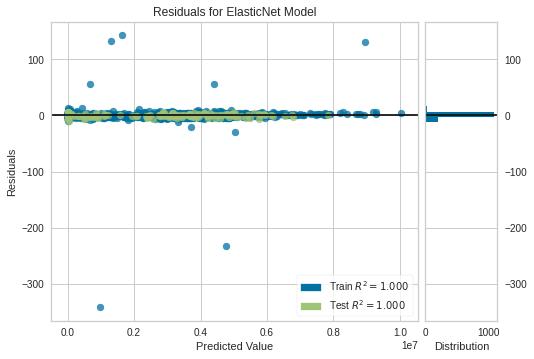

In [19]:
plot_model(tuned_model)

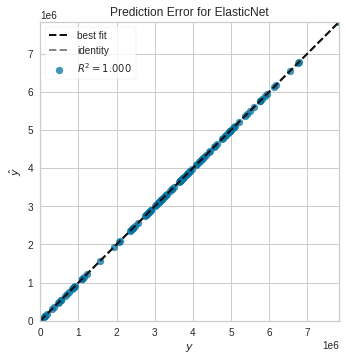

In [20]:
plot_model(tuned_model, plot = 'error')

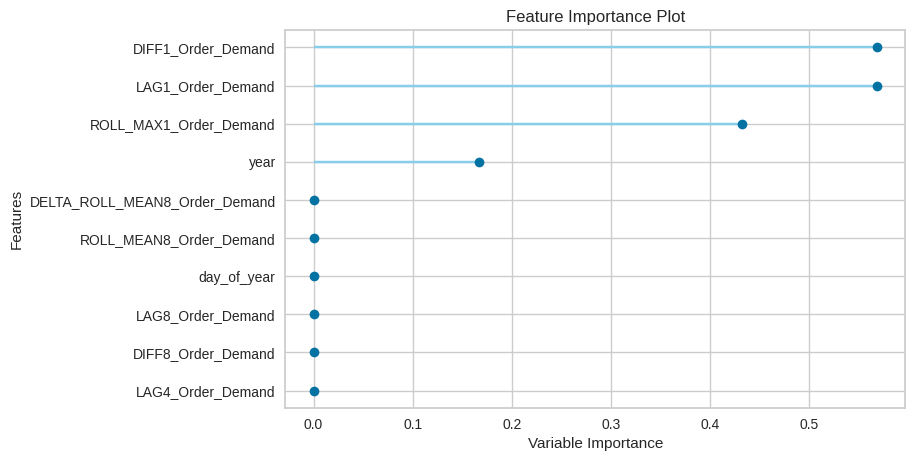

In [21]:
plot_model(tuned_model, plot='feature')

In [23]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Random Forest Regressor

In [40]:
lags = [2,4,7,15,30, 60]
train2 = train.copy()
new_features2 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            train2['LAG{}_{}'.format(l, f)] = train2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            train2['DIFF{}_{}'.format(l, f)] = train2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            train2['ROLL_MEAN{}_{}'.format(l, f)] = train2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            train2['ROLL_MAX{}_{}'.format(l, f)] = train2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            train2['ROLL_MIN{}_{}'.format(l, f)] = train2[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            train2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = train2[f] - train2[f].rolling(l).mean()

In [41]:
train2 = train2.fillna(-1)

In [43]:
train2

,Date,Order_Demand,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand
0,2012-01-01,2.0,1,1,2012,6,1,52,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00
1,2012-01-02,680277.0,2,1,2012,0,2,1,-1.0,-1.0,340139.5,680277.0,2.0,340137.5,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00
2,2012-01-03,1645257.0,3,1,2012,1,3,1,2.0,1645255.0,1162767.0,1645257.0,680277.0,482490.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00
3,2012-01-04,1295861.0,4,1,2012,2,4,1,680277.0,615584.0,1470559.0,1645257.0,1295861.0,-174698.0,-1.0,-1.0,905349.25,1645257.0,2.0,390511.75,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00
4,2012-01-05,8941774.0,5,1,2012,3,5,1,1645257.0,7296517.0,5118817.5,8941774.0,1295861.0,3822956.5,2.0,8941772.0,3140792.25,8941774.0,680277.0,5800981.75,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2015-12-27,535664.0,27,12,2015,6,361,52,2755472.0,-2219808.0,267832.0,535664.0,0.0,267832.0,1214391.0,-678727.0,1740825.00,3672164.0,0.0,-1205161.00,711247.0,-175583.0,2.671780e+06,6751498.0,0.0,-2.136116e+06,0.0,535664.0,2.616186e+06,6751498.0,0.0,-2.080522e+06,3867809.0,-3332145.0,2.869681e+06,6751498.0,0.0,-2.334017e+06,2435968.0,-1900304.0,2.794300e+06,6751498.0,0.0,-2.258636e+06
1457,2015-12-28,5430698.0,28,12,2015,0,362,53,0.0,5430698.0,2983181.0,5430698.0,535664.0,2447517.0,3672164.0,1758534.0,2180458.50,5430698.0,0.0,3250239.50,6751498.0,-1320800.0,2.483095e+06,5430698.0,0.0,2.947603e+06,2836100.0,2594598.0,2.789159e+06,6751498.0,0.0,2.641539e+06,0.0,5430698.0,3.050704e+06,6751498.0,0.0,2.379994e+06,3104272.0,2326426.0,2.833074e+06,6751498.0,0.0,2.597624e+06
1458,2015-12-29,658788.0,29,12,2015,1,363,53,535664.0,123124.0,3044743.0,5430698.0,658788.0,-2385955.0,2755472.0,-2096684.0,1656287.50,5430698.0,0.0,-997499.50,3773273.0,-3114485.0,2.038168e+06,5430698.0,0.0,-1.379380e+06,3281766.0,-2622978.0,2.614294e+06,6751498.0,0.0,-1.955506e+06,895551.0,-236763.0,3.042812e+06,6751498.0,0.0,-2.384024e+06,3402204.0,-2743416.0,2.787351e+06,6751498.0,0.0,-2.128563e+06
1459,2015-12-30,469744.0,30,12,2015,2,364,53,5430698.0,-4960954.0,564266.0,658788.0,469744.0,-94522.0,0.0,469744.0,1773723.50,5430698.0,469744.0,-130

In [44]:
#from pycaret.regression import *
exp_reg101 = setup(train2, target = 'Order_Demand', train_size = 0.80,
              data_split_shuffle = False,
              ignore_features = ['Date'],
              numeric_features = ['day_of_year', 'year'] + list(new_features2),
              categorical_features = ['month', 'day_of_week', 'day'],
              silent = True, verbose = False, session_id = 123)

In [45]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,705563.5151,1.761614e+12,1.327258e+06,0.5458,3.2520,11381.4877
1,37548.9653,5.683527e+09,7.538917e+04,0.9987,1.0274,0.0992
2,104541.5443,1.898560e+10,1.377882e+05,0.9937,2.5206,0.6413
3,70065.4404,1.953465e+10,1.397664e+05,0.9952,1.2075,0.1568
4,32087.2472,3.070914e+09,5.541583e+04,0.9992,0.4069,0.3760
5,50844.4909,9.364335e+09,9.676949e+04,0.9979,0.4695,0.2263
6,44957.2305,5.499124e+09,7.415608e+04,0.9987,0.3818,0.4089
7,54728.3269,9.340649e+09,9.664703e+04,0.9980,0.3265,0.2045
8,33125.1391,3.992582e+09,6.318688e+04,0.9990,0.9881,0.1137
9,143427.8859,5.254973e+10,2.292373e+05,0.9905,1.0877,0.0935


In [46]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,376688.3249,5.666053e+11,752731.8648,0.8539,3.4772,9362.6147
1,87749.5810,3.911128e+10,197765.7212,0.9909,3.0785,1.8662
2,124928.0030,2.431349e+10,155927.8268,0.9919,3.2721,6.8140
3,101791.8806,2.414546e+10,155388.0821,0.9941,2.6304,3.5314
4,54462.4929,5.511717e+09,74240.9421,0.9986,2.8199,4.9363
5,80009.8396,2.413883e+10,155366.7547,0.9946,2.4749,11.5906
6,80635.6136,1.419185e+10,119129.5720,0.9968,1.7829,4.6145
7,69906.3502,1.957434e+10,139908.3186,0.9958,2.4716,45.8205
8,57835.0613,7.266386e+09,85243.1019,0.9982,2.5178,5.1012
9,180268.9979,6.360831e+10,252206.8717,0.9885,2.8395,30.3095


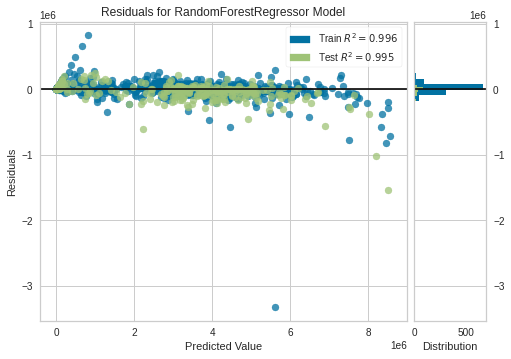

In [47]:
plot_model(tuned_rf)

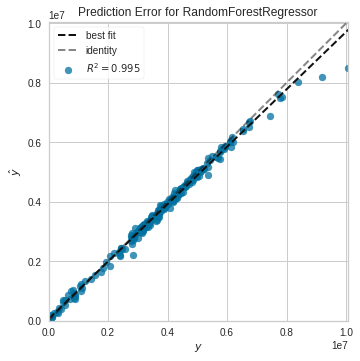

In [48]:
plot_model(tuned_rf, plot = 'error')

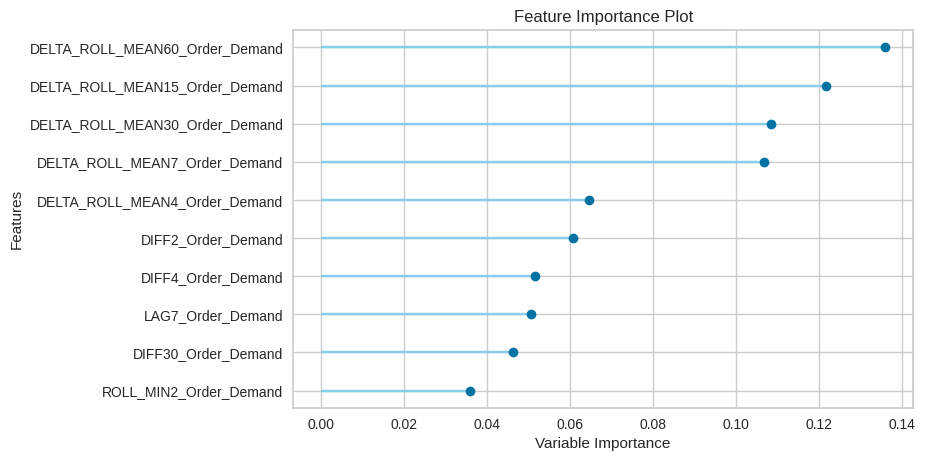

In [49]:
plot_model(tuned_rf, plot='feature')

In [53]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# 11.0 Predict on Test / Hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If you look at the information grid in Section 6 above, you will see that 30% (1621 samples) of the data has been separated out as a test/hold-out sample. All of the evaluation metrics we have seen above are cross-validated results based on training set (70%) only. Now, using our final trained model stored in the tuned_rf variable we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [54]:
predict_model(tuned_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,84251.7731,2.463808e+10,156965.2237,0.9949,3.4244,12.9661


# 12.0 Finalize Model for Deployment

In [55]:
final_rf = finalize_model(tuned_rf)

In [56]:
print(final_rf)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


In [57]:
predict_model(final_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,41785.0844,7.861148e+09,88663.1132,0.9984,3.1779,8.7061


# 13.0 Predict on Unseen Data

In [68]:
lags = [2,4,7,15,30,60]
val2 = val.copy()
new_features2 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            val2['LAG{}_{}'.format(l, f)] = val2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            val2['DIFF{}_{}'.format(l, f)] = val2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            val2['ROLL_MEAN{}_{}'.format(l, f)] = val2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            val2['ROLL_MAX{}_{}'.format(l, f)] = val2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            val2['ROLL_MIN{}_{}'.format(l, f)] = val2[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            val2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = val2[f] - val2[f].rolling(l).mean()

In [69]:
val2 = val2.fillna(-1)

In [70]:
unseen_predictions = predict_model(final_rf, data=val2)
unseen_predictions.head()

,Date,Order_Demand,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand,Label
1461,2016-01-01,0.0,1,1,2016,4,1,53,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.530057e+05
1462,2016-01-02,0.0,2,1,2016,5,2,53,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.886627e+05
1463,2016-01-03,95439.0,3,1,2016,6,3,53,0.0,95439.0,47719.5,95439.0,0.0,47719.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.801333e+05
1464,2016-01-04,1974541.0,4,1,2016,0,4,1,0.0,1974541.0,1034990.0,1974541.0,95439.0,939551.0,-1.0,-1.0,517495.0,1974541.0,0.0,1457046.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.788106e+06
1465,2016-01-05,4020468.0,5,1,2016,1,5,1,95439.0,3925029.0,2997504.5,4020468.0,1974541.0,1022963.5,0.0,4020468.0,1522612.0,4020468.0,0.0,2497856.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.284813e+06


In [71]:
from pycaret.utils import check_metric
print(check_metric(unseen_predictions.Order_Demand, unseen_predictions.Label, 'R2'))
print(check_metric(unseen_predictions.Order_Demand, unseen_predictions.Label, 'MAE'))

0.9757
162005.0231


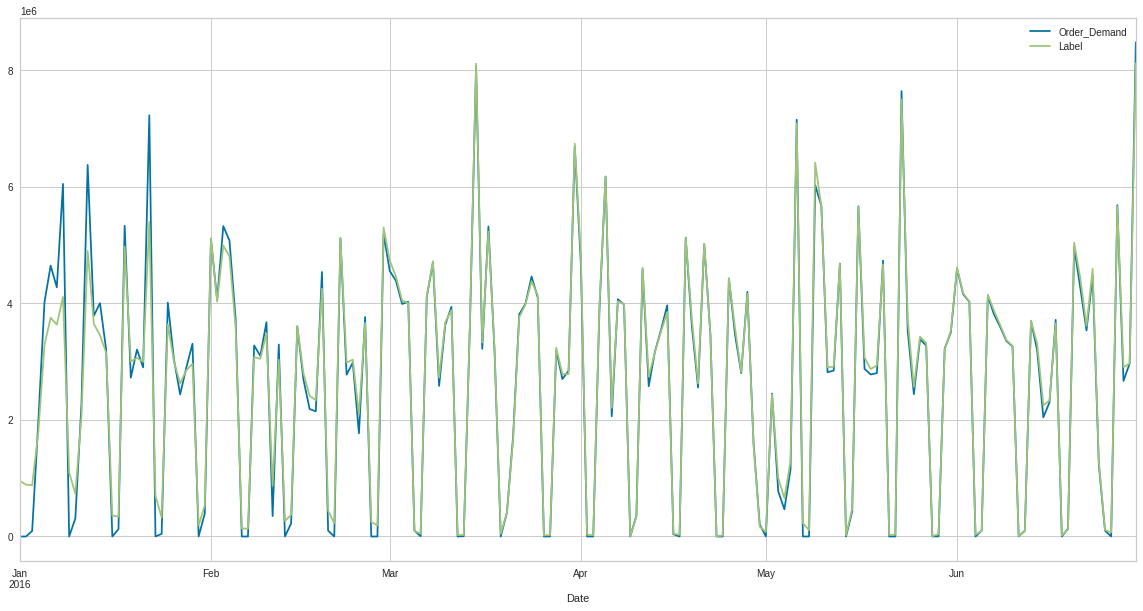

In [81]:
unseen_predictions.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)

# 14.0 Saving the Model

In [65]:
save_model(final_rf,'Final Random Forest Model 28 Jun 2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week',
                                                             'day'],
                                       display_types=False,
                                       features_todrop=['Date'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=['day_of_year',
                                                           'year'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_...
                  RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                        criteri

# 15.0 Loading the Saved Model

In [58]:
lags = [2,4,7,15,30, 60]
test2 = test.copy()
new_features3 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            test2['LAG{}_{}'.format(l, f)] = test2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            test2['DIFF{}_{}'.format(l, f)] = test2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            test2['ROLL_MEAN{}_{}'.format(l, f)] = test2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            test2['ROLL_MAX{}_{}'.format(l, f)] = test2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            test2['ROLL_MIN{}_{}'.format(l, f)] = test2[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            test2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = test2[f] - test2[f].rolling(l).mean()

In [59]:
test2 = test2.fillna(-1)

In [66]:
saved_final_lightgbm = load_model('Final Random Forest Model 28 Jun 2021')

Transformation Pipeline and Model Successfully Loaded


In [72]:
new_prediction = predict_model(saved_final_lightgbm, data=test2)

In [73]:
new_prediction.head()

,Date,Order_Demand,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand,Label
1643,2016-07-01,4311442.0,1,7,2016,4,183,26,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.015398e+06
1644,2016-07-02,0.0,2,7,2016,5,184,26,-1.0,-1.0,2155721.0,4311442.0,0.0,-2155721.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.638157e+06
1645,2016-07-03,0.0,3,7,2016,6,185,26,4311442.0,-4311442.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.322169e+05
1646,2016-07-04,7044944.0,4,7,2016,0,186,27,0.0,7044944.0,3522472.0,7044944.0,0.0,3522472.0,-1.0,-1.0,2839096.5,7044944.0,0.0,4205847.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.949438e+06
1647,2016-07-05,4012352.0,5,7,2016,1,187,27,0.0,4012352.0,5528648.0,7044944.0,4012352.0,-1516296.0,4311442.0,-299090.0,2764324.0,7044944.0,0.0,1248028.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.352293e+06


In [75]:
from pycaret.utils import check_metric
print(check_metric(new_prediction.Order_Demand, new_prediction.Label, 'R2'))
print(check_metric(new_prediction.Order_Demand, new_prediction.Label, 'MAE'))

0.9403
214220.6155


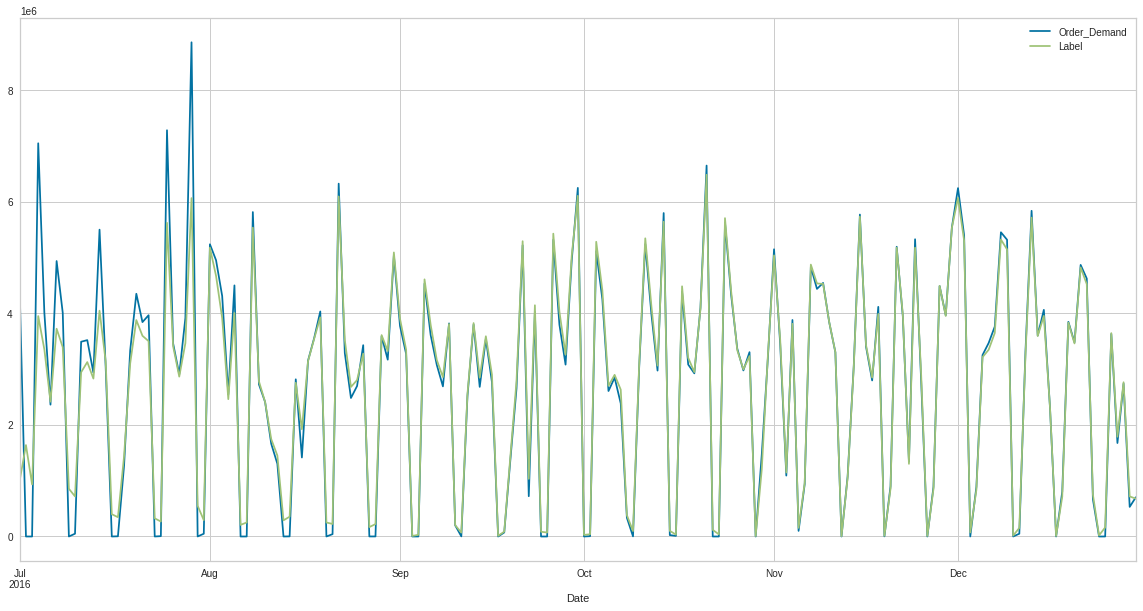

In [80]:

new_prediction.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)


# NOVO TESTE ENSEMBLE

In [91]:
exp_reg102 = setup(data = train2, target = 'Order_Demand', session_id=123,
                  #normalize = True, transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  #remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  ignore_features = ['Date'],
                  numeric_features = ['day_of_year', 'year'] + list(new_features2),
                  categorical_features = ['month', 'day_of_week', 'day'],
                  silent = True, verbose = False)

In [92]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,2.744459e+02,7.272684e+07,2.749903e+03,1.000000e+00,0.2338,0.0046,0.019
lasso,Lasso Regression,2.480448e+03,1.124879e+08,7.100797e+03,1.000000e+00,2.0448,14.5398,0.046
en,Elastic Net,1.637164e+03,9.700032e+07,5.537334e+03,1.000000e+00,1.8720,11.9440,0.043
llar,Lasso Least Angle Regression,6.922000e+01,4.077041e+05,2.552617e+02,1.000000e+00,1.1007,0.5297,0.019
br,Bayesian Ridge,5.681352e+02,7.354787e+07,3.070064e+03,1.000000e+00,0.9393,0.1289,0.060
par,Passive Aggressive Regressor,3.995400e+02,7.270653e+07,2.812982e+03,1.000000e+00,1.2473,0.0802,0.052
ridge,Ridge Regression,1.405023e+03,5.091050e+08,1.281357e+04,9.999000e-01,0.2027,0.0042,0.021
huber,Huber Regressor,2.554391e+04,4.230342e+10,1.517440e+05,9.906000e-01,2.1580,0.9796,0.091
et,Extra Trees Regressor,5.978565e+04,4.838473e+10,1.589477e+05,9.893000e-01,1.5590,437.1654,1.090
lightgbm,Light Gradient Boosting Machine,9.093095e+04,6.275171e+10,2.082213e+05,9.860000e-01,2.8672,589.7689,0.397


In [93]:
# train individual models to blend
lightgbm = create_model('lightgbm', verbose = False)
knn = create_model('knn', verbose = False)
lr = create_model('lr', verbose = False)

In [96]:
stacker = stack_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.8298,5.312500e+00,2.3049,1.0000,0.3224,0.0018
1,1.7499,5.356600e+00,2.3144,1.0000,0.2699,0.0029
2,37.2316,1.116394e+05,334.1248,1.0000,0.3557,0.0462
3,5.9105,2.078080e+03,45.5860,1.0000,0.2910,0.0001
4,1.6402,4.458400e+00,2.1115,1.0000,0.3432,0.0005
5,1.4994,3.450400e+00,1.8575,1.0000,0.4541,0.0011
6,75.3917,5.510353e+05,742.3175,1.0000,0.2119,0.0017
7,1244.5355,1.577207e+08,12558.6914,1.0000,0.1202,0.0021
8,1.1713,2.217300e+00,1.4891,1.0000,0.1078,0.0002
9,7010.6440,2.974180e+09,54536.0469,0.9993,0.4251,0.0095


In [97]:
# to start the MLFlow server from notebook:
!mlflow ui

[2021-06-29 01:55:23 +0000] [21521] [INFO] Starting gunicorn 20.1.0
[2021-06-29 01:55:23 +0000] [21521] [INFO] Listening at: http://127.0.0.1:5000 (21521)
[2021-06-29 01:55:23 +0000] [21521] [INFO] Using worker: sync
[2021-06-29 01:55:23 +0000] [21524] [INFO] Booting worker with pid: 21524
[2021-06-29 01:59:11 +0000] [21521] [INFO] Handling signal: int

Aborted!
[2021-06-29 01:59:11 +0000] [21524] [INFO] Worker exiting (pid: 21524)
[2021-06-29 01:59:11 +0000] [21521] [INFO] Shutting down: Master
